# Sparkify Project Workspace
This workspace contains a tiny subset (128MB) of the full dataset available (12GB). Feel free to use this workspace to build your project, or to explore a smaller subset with Spark before deploying your cluster on the cloud. Instructions for setting up your Spark cluster is included in the last lesson of the Extracurricular Spark Course content.

You can follow the steps below to guide your data analysis and model building portion of this project.

In [1]:
# import libraries
from pyspark.sql import SparkSession
from pyspark.sql.functions import udf, avg,desc
from pyspark.sql.types import IntegerType
from pyspark.ml.feature import VectorAssembler, StringIndexer
from pyspark.ml.classification import LogisticRegression
from pyspark.ml import Pipeline
from pyspark.ml.evaluation import MulticlassClassificationEvaluator
from pyspark.ml.tuning import CrossValidator, ParamGridBuilder

import matplotlib.pyplot as plt
%matplotlib inline
import pandas as pd
import seaborn as sns
import datetime

In [2]:
# create a Spark session
spark = SparkSession.builder \
    .master("local") \
    .appName("Sparkify") \
    .getOrCreate()

# Load and Clean Dataset
In this workspace, the mini-dataset file is `mini_sparkify_event_data.json`. Load and clean the dataset, checking for invalid or missing data - for example, records without userids or sessionids. 

In [3]:
stack_overflow_data = 'mini_sparkify_event_data.json'
df = spark.read.json(stack_overflow_data)
df.printSchema()

root
 |-- artist: string (nullable = true)
 |-- auth: string (nullable = true)
 |-- firstName: string (nullable = true)
 |-- gender: string (nullable = true)
 |-- itemInSession: long (nullable = true)
 |-- lastName: string (nullable = true)
 |-- length: double (nullable = true)
 |-- level: string (nullable = true)
 |-- location: string (nullable = true)
 |-- method: string (nullable = true)
 |-- page: string (nullable = true)
 |-- registration: long (nullable = true)
 |-- sessionId: long (nullable = true)
 |-- song: string (nullable = true)
 |-- status: long (nullable = true)
 |-- ts: long (nullable = true)
 |-- userAgent: string (nullable = true)
 |-- userId: string (nullable = true)



In [4]:
df.count()

286500

In [5]:
df.head()

Row(artist='Martha Tilston', auth='Logged In', firstName='Colin', gender='M', itemInSession=50, lastName='Freeman', length=277.89016, level='paid', location='Bakersfield, CA', method='PUT', page='NextSong', registration=1538173362000, sessionId=29, song='Rockpools', status=200, ts=1538352117000, userAgent='Mozilla/5.0 (Windows NT 6.1; WOW64; rv:31.0) Gecko/20100101 Firefox/31.0', userId='30')

In [6]:
df.describe('userId').show()

+-------+-----------------+
|summary|           userId|
+-------+-----------------+
|  count|           286500|
|   mean|59682.02278593872|
| stddev|109091.9499991047|
|    min|                 |
|    max|               99|
+-------+-----------------+



In [7]:
user_log_valid = df.dropna(how = "any", subset = ["userId", "sessionId"])

In [8]:
user_log_valid = user_log_valid.filter(user_log_valid["userId"] != "")

In [9]:
user_log_valid.count()

278154

# Exploratory Data Analysis
When you're working with the full dataset, perform EDA by loading a small subset of the data and doing basic manipulations within Spark. In this workspace, you are already provided a small subset of data you can explore.

### Define Churn

Once you've done some preliminary analysis, create a column `Churn` to use as the label for your model. I suggest using the `Cancellation Confirmation` events to define your churn, which happen for both paid and free users. As a bonus task, you can also look into the `Downgrade` events.

### Explore Data
Once you've defined churn, perform some exploratory data analysis to observe the behavior for users who stayed vs users who churned. You can start by exploring aggregates on these two groups of users, observing how much of a specific action they experienced per a certain time unit or number of songs played.

In [10]:
user_log_valid.select("page").dropDuplicates().sort("page").show()

+--------------------+
|                page|
+--------------------+
|               About|
|          Add Friend|
|     Add to Playlist|
|              Cancel|
|Cancellation Conf...|
|           Downgrade|
|               Error|
|                Help|
|                Home|
|              Logout|
|            NextSong|
|         Roll Advert|
|       Save Settings|
|            Settings|
|    Submit Downgrade|
|      Submit Upgrade|
|         Thumbs Down|
|           Thumbs Up|
|             Upgrade|
+--------------------+



In [11]:
user_log_valid.filter("page = 'Cancellation Confirmation'").show()

+------+---------+---------+------+-------------+---------+------+-----+--------------------+------+--------------------+-------------+---------+----+------+-------------+--------------------+------+
|artist|     auth|firstName|gender|itemInSession| lastName|length|level|            location|method|                page| registration|sessionId|song|status|           ts|           userAgent|userId|
+------+---------+---------+------+-------------+---------+------+-----+--------------------+------+--------------------+-------------+---------+----+------+-------------+--------------------+------+
|  null|Cancelled|   Adriel|     M|          104|  Mendoza|  null| paid|  Kansas City, MO-KS|   GET|Cancellation Conf...|1535623466000|      514|null|   200|1538943990000|"Mozilla/5.0 (Mac...|    18|
|  null|Cancelled|    Diego|     M|           56|    Mckee|  null| paid|Phoenix-Mesa-Scot...|   GET|Cancellation Conf...|1537167593000|      540|null|   200|1539033046000|"Mozilla/5.0 (iPh...|    32|


In [12]:
downgrade_event = udf(lambda x: 1 if x == "Cancellation Confirmation" else 0, IntegerType())

In [13]:
user_log_cancel = user_log_valid.withColumn("Churn", downgrade_event("page"))

In [14]:
user_log_cancel.select(['userId','gender','level','ts']).where(user_log_cancel.Churn== 1).sort('ts').collect()

[Row(userId='100011', gender='M', level='free', ts=1538417085000),
 Row(userId='100001', gender='F', level='free', ts=1538498205000),
 Row(userId='100024', gender='M', level='free', ts=1538695038000),
 Row(userId='300007', gender='M', level='paid', ts=1538705338000),
 Row(userId='100006', gender='F', level='free', ts=1538753070000),
 Row(userId='18', gender='M', level='paid', ts=1538943990000),
 Row(userId='100019', gender='M', level='free', ts=1538953071000),
 Row(userId='32', gender='M', level='paid', ts=1539033046000),
 Row(userId='100003', gender='F', level='free', ts=1539274781000),
 Row(userId='125', gender='M', level='free', ts=1539318918000),
 Row(userId='105', gender='M', level='paid', ts=1539375441000),
 Row(userId='17', gender='F', level='paid', ts=1539465584000),
 Row(userId='100023', gender='M', level='paid', ts=1539475237000),
 Row(userId='143', gender='F', level='free', ts=1539588854000),
 Row(userId='200001', gender='M', level='free', ts=1539629720000),
 Row(userId='101

In [15]:
get_hour = udf(lambda x: datetime.datetime.fromtimestamp(x / 1000.0). hour)
user_log_cancel = user_log_cancel.withColumn("hour", get_hour(user_log_cancel.ts))

In [16]:
user_log_cancel.head()

Row(artist='Martha Tilston', auth='Logged In', firstName='Colin', gender='M', itemInSession=50, lastName='Freeman', length=277.89016, level='paid', location='Bakersfield, CA', method='PUT', page='NextSong', registration=1538173362000, sessionId=29, song='Rockpools', status=200, ts=1538352117000, userAgent='Mozilla/5.0 (Windows NT 6.1; WOW64; rv:31.0) Gecko/20100101 Firefox/31.0', userId='30', Churn=0, hour='0')

In [17]:
user_log_cancel.printSchema()

root
 |-- artist: string (nullable = true)
 |-- auth: string (nullable = true)
 |-- firstName: string (nullable = true)
 |-- gender: string (nullable = true)
 |-- itemInSession: long (nullable = true)
 |-- lastName: string (nullable = true)
 |-- length: double (nullable = true)
 |-- level: string (nullable = true)
 |-- location: string (nullable = true)
 |-- method: string (nullable = true)
 |-- page: string (nullable = true)
 |-- registration: long (nullable = true)
 |-- sessionId: long (nullable = true)
 |-- song: string (nullable = true)
 |-- status: long (nullable = true)
 |-- ts: long (nullable = true)
 |-- userAgent: string (nullable = true)
 |-- userId: string (nullable = true)
 |-- Churn: integer (nullable = true)
 |-- hour: string (nullable = true)



In [18]:
user_log_cancel.groupby("Churn").count().show()

+-----+------+
|Churn| count|
+-----+------+
|    1|    52|
|    0|278102|
+-----+------+



In [19]:
user_log_cancel.describe("artist").show()

+-------+------------------+
|summary|            artist|
+-------+------------------+
|  count|            228108|
|   mean| 551.0852017937219|
| stddev|1217.7693079161374|
|    min|               !!!|
|    max| ÃÂlafur Arnalds|
+-------+------------------+



In [20]:
user_log_cancel.select(['page','artist']).where(user_log_cancel.page=='NextSong').groupby(user_log_cancel.artist).agg({'artist':'count'}).sort(desc('count(artist)')).show(5)

+--------------------+-------------+
|              artist|count(artist)|
+--------------------+-------------+
|       Kings Of Leon|         1841|
|            Coldplay|         1813|
|Florence + The Ma...|         1236|
|       Dwight Yoakam|         1135|
|            BjÃÂ¶rk|         1133|
+--------------------+-------------+
only showing top 5 rows



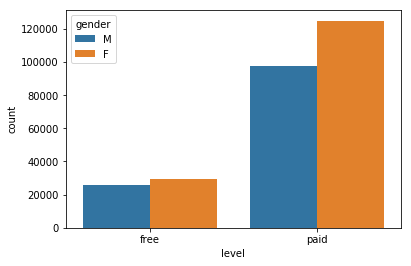

In [21]:
df_pd = user_log_cancel.groupby(["level","gender"]).count().toPandas()
sns.barplot(x='level', y='count', hue='gender', data=df_pd)

In [22]:
songs_in_hour = user_log_cancel.filter(user_log_cancel.page == "NextSong").groupby(user_log_cancel.hour).count().orderBy(user_log_cancel.hour.cast("float"))


In [23]:
songs_in_hour_pd = songs_in_hour.toPandas()

songs_in_hour_pd.hour = pd.to_numeric(songs_in_hour_pd.hour)

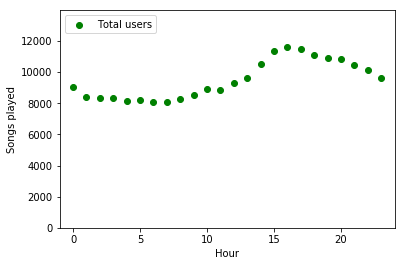

In [24]:
plt.scatter(songs_in_hour_pd["hour"], songs_in_hour_pd["count"], c='g', label='Total users')
plt.xlim(-1, 24);
plt.ylim(0, 1.2 * max(songs_in_hour_pd["count"]))
plt.legend(loc='upper left')
plt.xlabel("Hour")
plt.ylabel("Songs played")
plt.show();

# Feature Engineering
Once you've familiarized yourself with the data, build out the features you find promising to train your model on. To work with the full dataset, you can follow the following steps.
- Write a script to extract the necessary features from the smaller subset of data
- Ensure that your script is scalable, using the best practices discussed in Lesson 3
- Try your script on the full data set, debugging your script if necessary

If you are working in the classroom workspace, you can just extract features based on the small subset of data contained here. Be sure to transfer over this work to the larger dataset when you work on your Spark cluster.

In [25]:
#build pipeline
Gender_indexer = StringIndexer(inputCol="gender", outputCol='Gender_index')
User_indexer = StringIndexer(inputCol="userAgent", outputCol='User_index')
Page_indexer = StringIndexer(inputCol="page", outputCol='Page_index')
Level_indexer= StringIndexer(inputCol="level", outputCol='Level_index')
indexer = StringIndexer(inputCol="Churn", outputCol="label")

assembler = VectorAssembler(inputCols=["Gender_index", "User_index", "Page_index", "status","Level_index"], outputCol="features")


# Modeling
Split the full dataset into train, test, and validation sets. Test out several of the machine learning methods you learned. Evaluate the accuracy of the various models, tuning parameters as necessary. Determine your winning model based on test accuracy and report results on the validation set. Since the churned users are a fairly small subset, I suggest using F1 score as the metric to optimize.

In [26]:
rest, validation = user_log_cancel.randomSplit([0.8,0.2], seed=42)

In [27]:
lr =  LogisticRegression(maxIter=10, regParam=0.0, elasticNetParam=0)

pipeline = Pipeline(stages=[Gender_indexer, User_indexer, Page_indexer,Level_indexer, indexer, assembler, lr])

In [28]:
paramGrid = ParamGridBuilder() \
    .addGrid(lr.regParam,[0.0, 0.1]) \
    .build()


crossval = CrossValidator(estimator=pipeline,
                          estimatorParamMaps=paramGrid,
                          evaluator=MulticlassClassificationEvaluator(),
                          numFolds=3)

In [29]:
cvModel_q1 = crossval.fit(rest)

In [30]:
cvModel_q1.avgMetrics

[1.0, 0.9997038941434033]

In [31]:
results = cvModel_q1.transform(validation)

In [32]:
print(results.filter(results.label == results.prediction).count())
print(results.count())

55174
55174


# Final Steps
Clean up your code, adding comments and renaming variables to make the code easier to read and maintain. Refer to the Spark Project Overview page and Data Scientist Capstone Project Rubric to make sure you are including all components of the capstone project and meet all expectations. Remember, this includes thorough documentation in a README file in a Github repository, as well as a web app or blog post.